In [ ]:
 import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.distributions import MultivariateNormal

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random




# vae using Encoder
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=200):
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (batch_size, 128, 4, 4)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=2)  # (batch_size, 128, 3, 3)
        )

        # Latent space
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2),  # (batch_size, 128, 2, 2)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 128, 4, 4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 1, 28, 28)
            #nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        return z

    def encode(self, x):
        x = self.encoder(x)
        # add average pooling
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 1, 1)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# vae directly optimize the q vectors
class ConvVAELatent(nn.Module):
    def __init__(self, latent_dim=200):
        super(ConvVAELatent, self).__init__()

        self.latent_dim = latent_dim

        # Latent space
        self.fc_decode = nn.Linear(latent_dim, 128)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2),  # (batch_size, 128, 2, 2)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 128, 4, 4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 1, 28, 28)
            #nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        return z


    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 1, 1)
        z = self.decoder(z)
        return z

    def forward(self, mu, logvar):
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x

# kl calculation for the loss function
def kl_divergence(mu, logvar):
   return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# pick randomaly 10 imgs labeled 0 - 9 from the dataset
def sample_one_image_per_label(dataset, device='cpu'):
    label_to_image = {}
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        img, label = dataset[idx]
        label = label.item() if isinstance(label, torch.Tensor) else label
        if label not in label_to_image:
            label_to_image[label] = img.unsqueeze(0).to(device)
        if len(label_to_image) == 10:
            break

    images = [label_to_image[i] for i in range(10)]
    return torch.cat(images, dim=0)  # shape: (10, 1, 28, 28)

# pick randomaly 10 imgs labeled 0 - 9 from the dataset
# the main different from the function above is that this one returns the corresponding mu and log_var for latent optimization
def sample_one_image_per_label_latent(dataset, mu_tensor, logvar_tensor, device='cpu'):
    label_to_index = {}
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        _, label = dataset[idx]
        label = label.item() if isinstance(label, torch.Tensor) else label
        if label not in label_to_index:
            label_to_index[label] = idx
        if len(label_to_index) == 10:
            break


    selected_indices = [label_to_index[i] for i in range(10)]
    images = [dataset[i][0].unsqueeze(0).to(device) for i in selected_indices]
    mus = [mu_tensor[i].unsqueeze(0).to(device) for i in selected_indices]
    logvars = [logvar_tensor[i].unsqueeze(0).to(device) for i in selected_indices]

    return (
        torch.cat(images, dim=0),       # shape: (10, 1, 28, 28)
        torch.cat(mus, dim=0),          # shape: (10, latent_dim)
        torch.cat(logvars, dim=0)       # shape: (10, latent_dim)
    )

# picking 5 randomaly imgs from the dataset
def sample_five_images_for_label(dataset, img_label, device='cpu'):
    images = []
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        img, label = dataset[idx]
        label = label.item() if isinstance(label, torch.Tensor) else label
        if label == img_label:
          images.append (img.unsqueeze(0).to(device))
        if len(images) == 5:
            break


    return torch.cat(images, dim=0)  # shape: (5, 1, 28, 28)

# Plots original and reconstructed images side-by-side.
def plot_vae_reconstructions(originals, reconstructions, title_prefix="Train"):

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        # Original
        axes[0, i].imshow(originals[i].squeeze().cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'{title_prefix}: {i}')

        # Reconstruction
        axes[1, i].imshow(reconstructions[i].squeeze().cpu(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Original", rotation=90, size='large')
    axes[1, 0].set_ylabel("Reconstructed", rotation=90, size='large')

    plt.tight_layout()
    plt.show()

# Plots a single row of 10 sampled/generated images.
def plot_sampled_images(samples, title_prefix="Sampled"):

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(samples[i].squeeze().cpu(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'{title_prefix}\n#{i}', fontsize=8)

    plt.suptitle(f"{title_prefix} Images", fontsize=14)
    plt.tight_layout()
    plt.show()


# compute log(p(x)) as explained in the targil instructions
def compute_log_px(x, model, M = 1000, sigma_p = 0.4):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(x.unsqueeze(0))
        mu = mu.squeeze(0)
        logvar = logvar.squeeze(0)
        sigma = torch.exp(0.5 * logvar)

        eps = torch.randn(M, mu.shape[0])
        z_samples = mu + sigma * eps

        log_weights = []
        x_flat = x.view(-1)

        for z in z_samples:
            decoded = model.decode(z.unsqueeze(0)).squeeze(0).view(-1)

            # log p(z)
            log_pz = log_normal_pdf(z, torch.zeros_like(z), torch.ones_like(z))

            # log p(x | z)
            log_pxz = log_normal_pdf(x_flat, decoded, torch.ones_like(decoded) * sigma_p**2)

            # log q(z)
            log_qz = log_normal_pdf(z, mu, logvar)

            log_weights.append(log_pz + log_pxz - log_qz)

        log_weights = torch.stack(log_weights)  # shape: (M,)
        return torch.logsumexp(log_weights, dim=0) - torch.log(torch.tensor(M, dtype=torch.float32))

# compute the probability of x from the normal distribution
def log_normal_pdf(x, mean, logvar):
    # shape: (D,)
    var = torch.exp(logvar)
    return -0.5 * (torch.sum(logvar + (x - mean)**2 / var) + x.shape[0] * torch.log(torch.tensor(2 * torch.pi)))

# hyper parameters
lr = 0.001
#batch_size = 64
num_epochs = 30
latent_dim = 200
sigma_p = 0.4
M = 1000
N = 20000

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# take a stratified subset of the training data, keeping only 5000 samples, with 500 samples per class
train_targets = train_dataset.targets
train_idx, _ = train_test_split(range(len(train_targets)), train_size=20000, stratify=train_targets)
train_dataset = torch.utils.data.Subset(train_dataset, train_idx)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class IndexedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        data, target = self.dataset[index]
        return data, target, index

    def __len__(self):
        return len(self.dataset)
indexed_train_dataset = IndexedDataset(train_dataset)
train_loader_latent = DataLoader(indexed_train_dataset, batch_size=64, shuffle=True, drop_last=True)





# train vae model with AE
def train_vae_model(model, optimizer, train_loader, test_loader, num_epochs):

  # Training loop
  train_losses = []
  val_losses = []
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      inputs, _ = data
      outputs, mu, logvar = model(inputs)
      mse_loss = F.mse_loss(outputs.view(-1, 28 * 28), inputs.view(-1, 28 * 28), reduction='sum')
      kl_loss = kl_divergence(mu, logvar)
      beta = torch.tensor(min(1.0, epoch / 10), dtype=torch.float32, device=inputs.device)

      optimizer.zero_grad()
      loss = mse_loss + kl_loss
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    epochs_done = epoch + 1
    model.eval()
    with torch.no_grad():
      running_val_loss = 0.0
      for data in test_loader:
        inputs, _ = data
        outputs, mu, logvar = model(inputs)
        mse_loss = F.mse_loss(outputs.view(-1, 28 * 28), inputs.view(-1, 28 * 28), reduction='sum')
        kl_loss = kl_divergence(mu, logvar)
        loss = mse_loss + kl_loss
        val_loss = loss.item()
        running_val_loss += val_loss
      epoch_val_loss = running_val_loss / len(test_loader)
      val_losses.append(epoch_val_loss)
    if epochs_done == 1 or epochs_done == 5 or epochs_done == 10 or epochs_done == 20 or epochs_done == 30:
      torch.save(model.state_dict(), f"vae_epoch_{epoch + 1}.pth")

  return train_losses, val_losses

# Initialize the vae_model,, and vae_optimizer
vae_model = ConvVAE(latent_dim)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=lr)
train_losses, val_losses = train_vae_model(vae_model, vae_optimizer, train_loader, test_loader, num_epochs)

# train vae model optimize q directly
def train_vae_latent_model(model, optimizer, train_loader, num_epochs):
  train_losses = []
  # Training loop
  for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0
      for batch_idx, (imgs, _, indices) in enumerate(train_loader):
        outputs = model(mu[indices], log_var[indices])
        kl = kl_divergence(mu[indices], log_var[indices])
        mse_loss = F.mse_loss(outputs.view(-1, 28 * 28), imgs.view(-1, 28 * 28), reduction='sum')

        optimizer.zero_grad()
        loss = mse_loss + kl
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

      epoch_loss = train_loss / len(train_loader)
      train_losses.append(epoch_loss)
      epochs_done = epoch + 1
      if epochs_done == 1 or epochs_done == 5 or epochs_done == 10 or epochs_done == 20 or epochs_done == 30:
        torch.save(model.state_dict(), f"vae_latent_epoch_{epoch + 1}.pth")
  return train_losses

# define q vectors and model and optimizer for the latent optimization
mu = nn.Parameter(torch.randn(N, latent_dim))
log_var = nn.Parameter(torch.randn(N, latent_dim))
latent_model = ConvVAELatent(latent_dim=latent_dim)
latent_optimizer = optim.Adam([
    {'params': latent_model.parameters(), 'lr': 0.001},         # decoder
    {'params': [mu, log_var], 'lr': 0.01}                # latent vectors
])

train_latent_losses = train_vae_latent_model(latent_model, latent_optimizer, train_loader_latent, num_epochs)







plot the train and test losses as asked in Q1

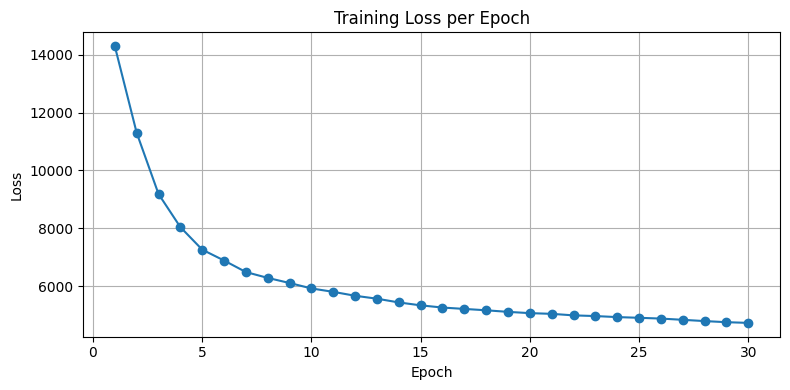

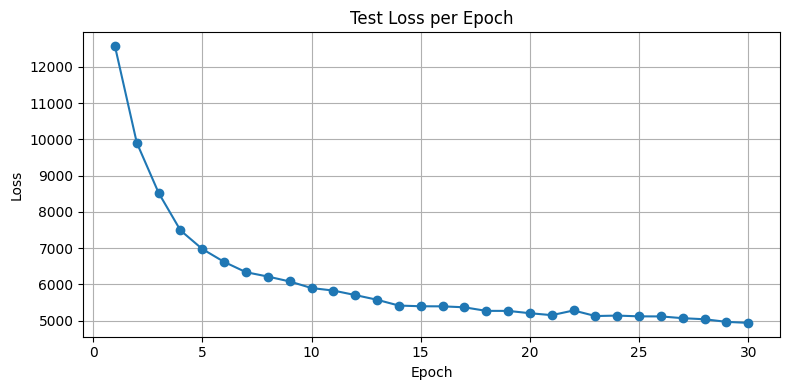

In [ ]:
def plot_loses(losses, title, num_epochs = 30 ):
  plt.figure(figsize=(8, 4))
  plt.plot(range(1, num_epochs + 1), losses, marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'{title} Loss per Epoch')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

plot_loses(train_losses , "Training")
plot_loses(val_losses, "Test")

plot 10 randomaly imgs and it's reconstructions from train and test data set in epochs 1, 5, 10, 20, 30 as asked in Q1

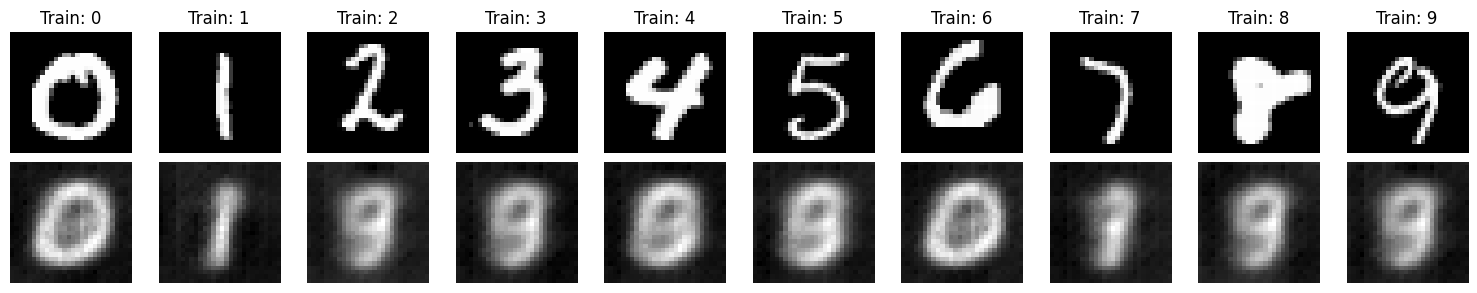

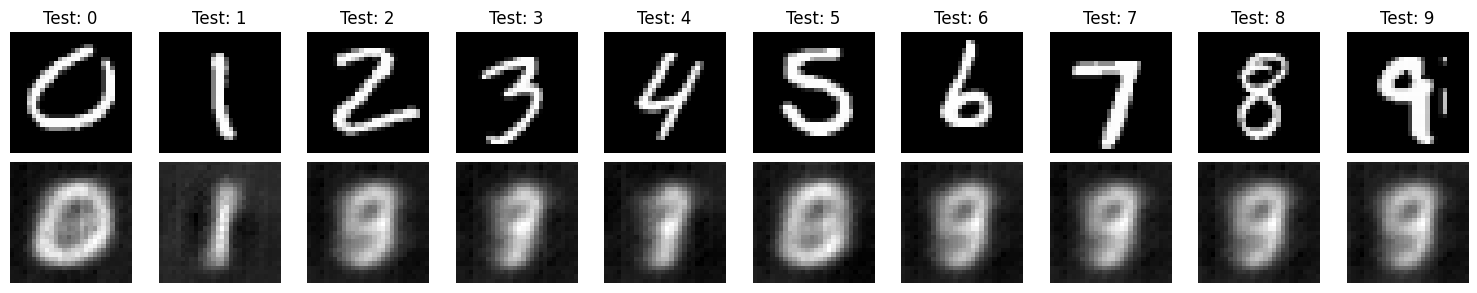

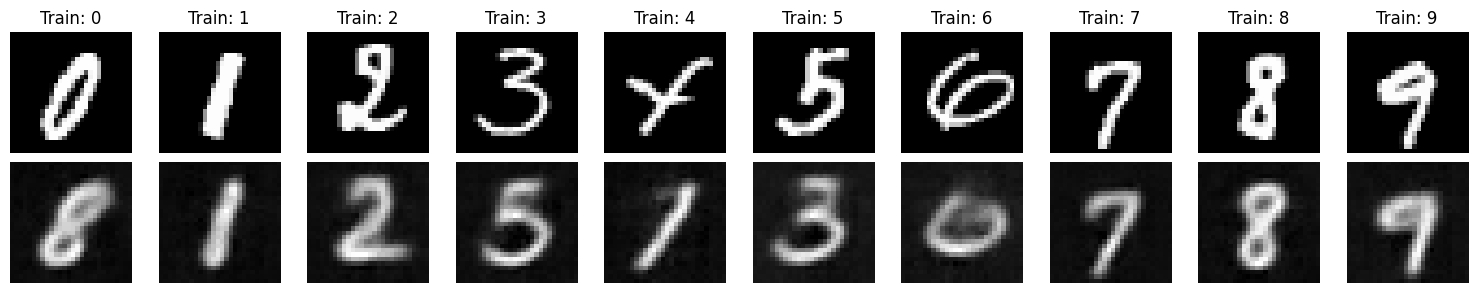

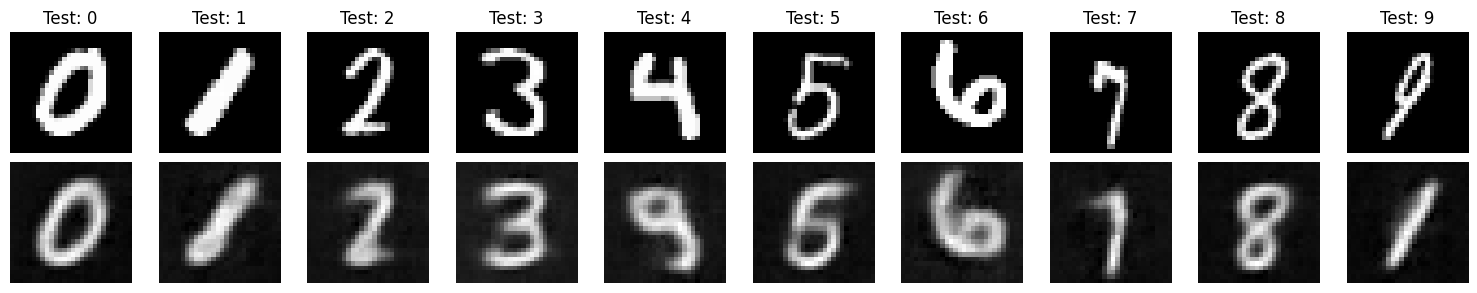

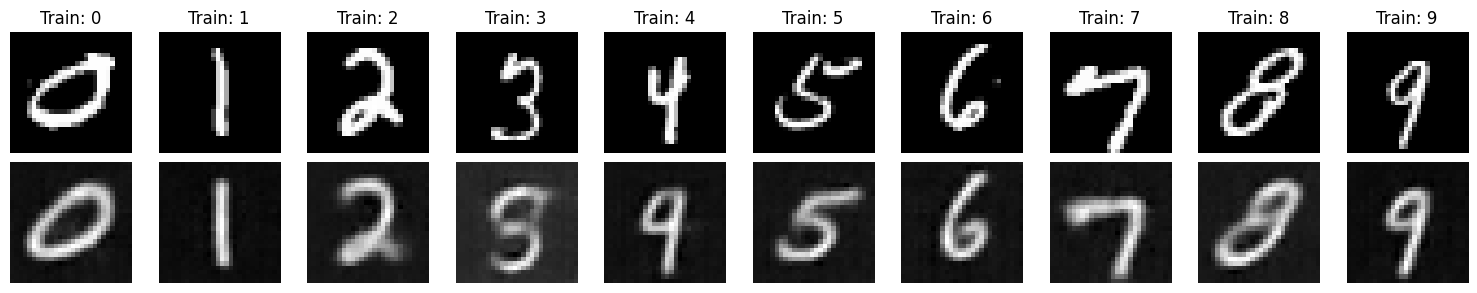

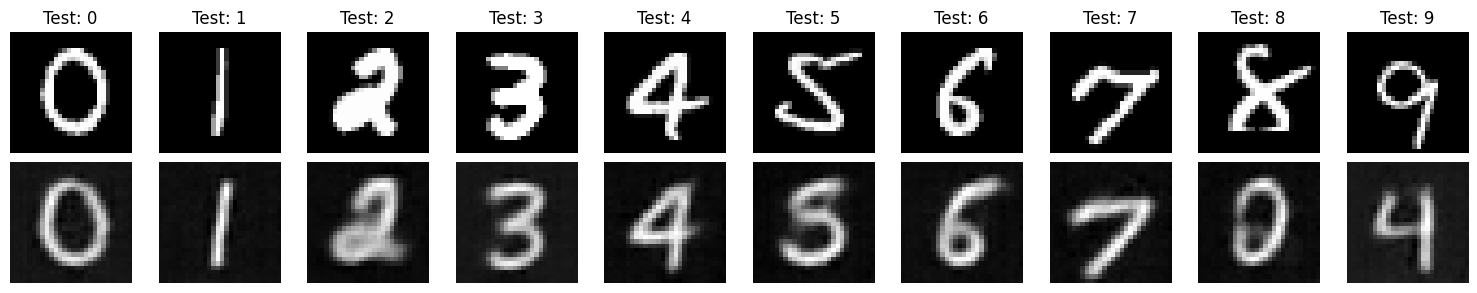

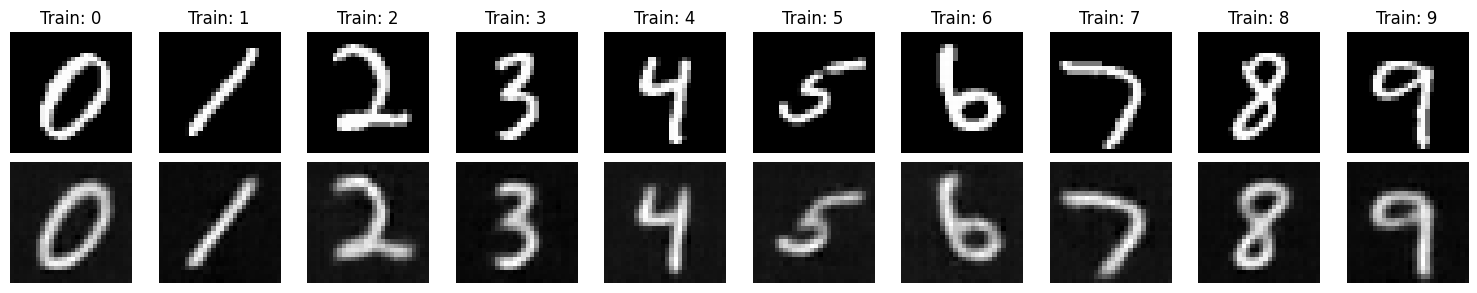

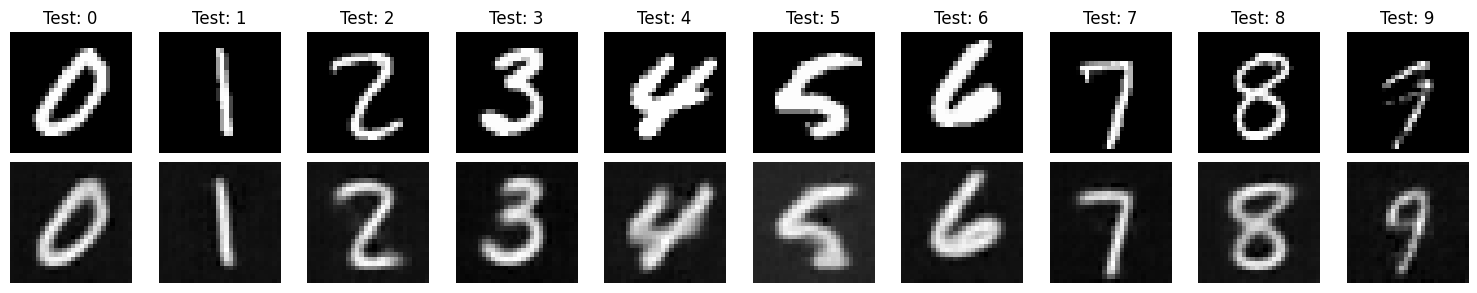

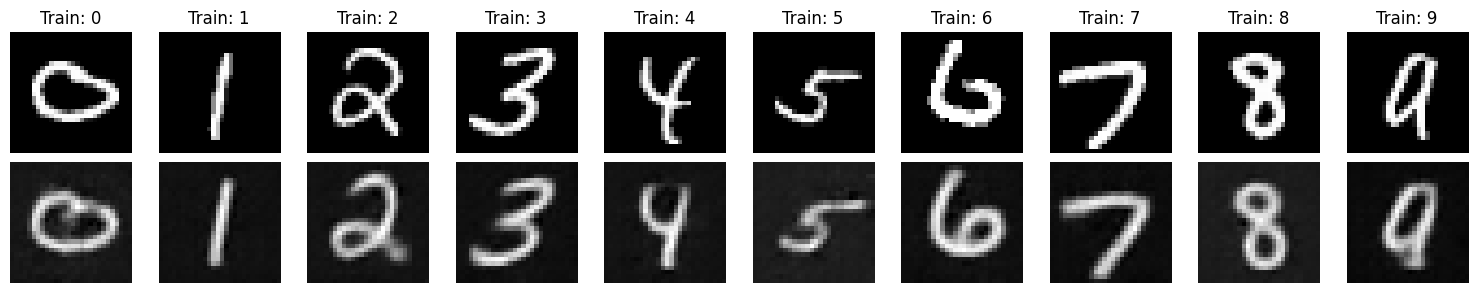

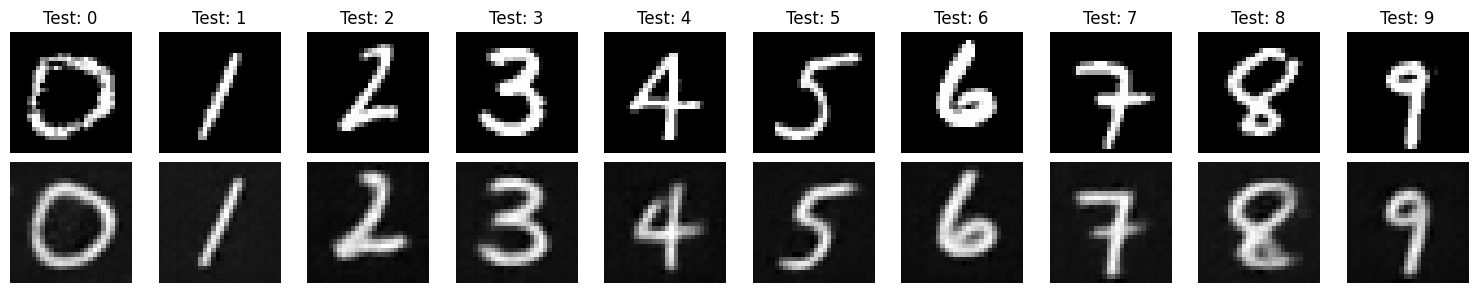

In [ ]:
def reconstruct_vae(model):
  for epoch_num in [1, 5, 10, 20, 30]:
      model.load_state_dict(torch.load(f"vae_epoch_{epoch_num}.pth"))
      model.eval()
      with torch.no_grad():
          # reconstruction
          train_images = sample_one_image_per_label(train_dataset)
          test_images = sample_one_image_per_label(test_dataset)
          recon_train, _, _ = model(train_images)
          recon_test, _, _ = model(test_images)
          plot_vae_reconstructions(train_images, recon_train, title_prefix="Train")
          plot_vae_reconstructions(test_images, recon_test, title_prefix="Test")
reconstruct_vae(vae_model)

 Sample 10 latent variables from prior distribution and passing them to the generators to try sample imgs in epochs 1, 5, 10, 20, 30 as asked in Q2

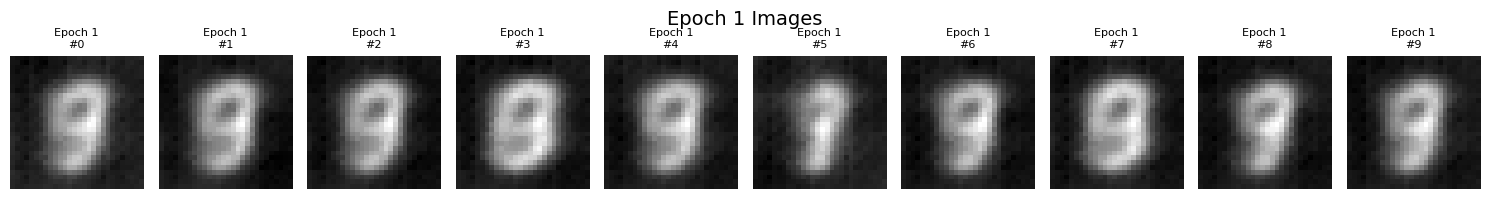

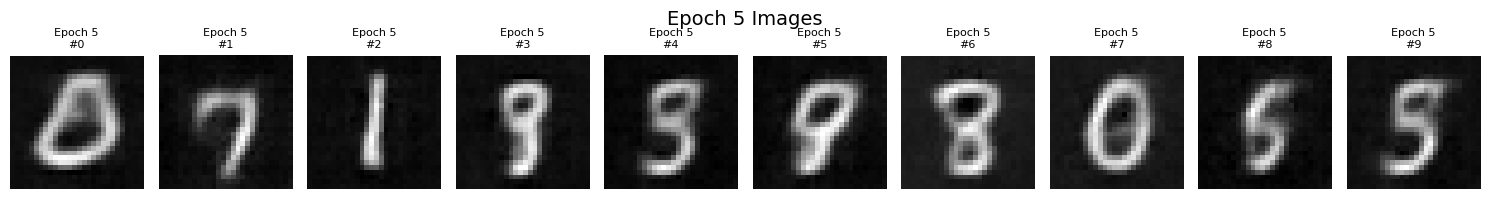

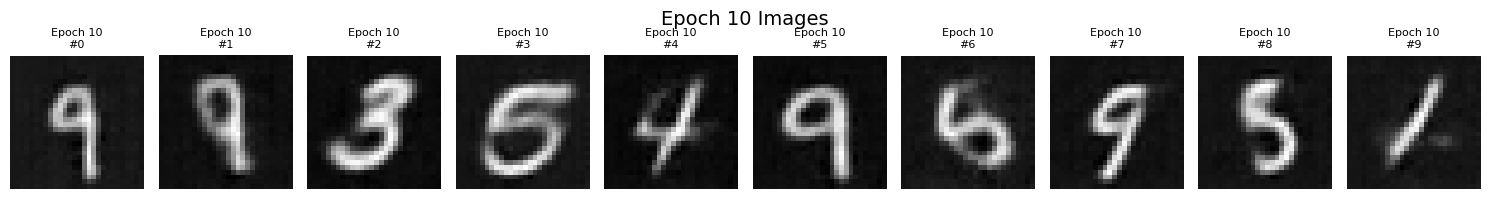

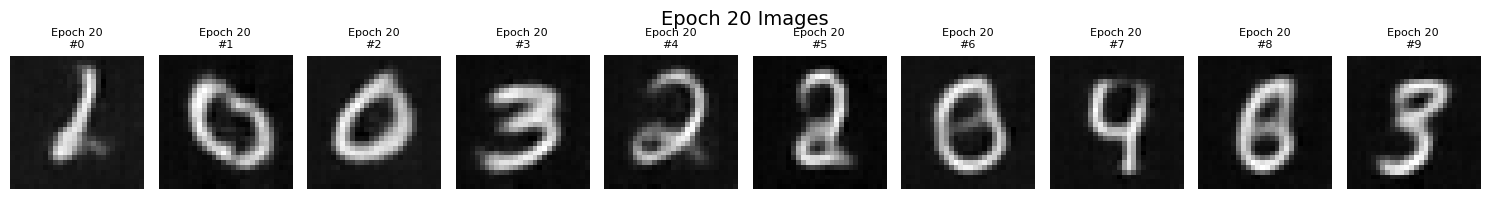

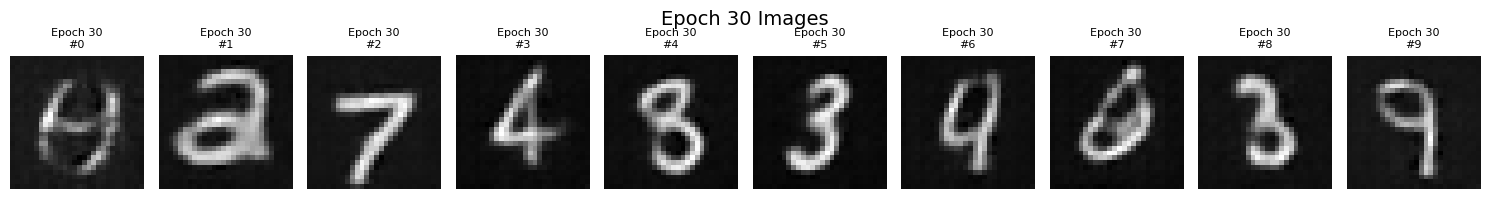

In [ ]:
def sampling(model, path):
  for epoch_num in [1, 5, 10, 20, 30]:
      model.load_state_dict(torch.load(f"{path}_{epoch_num}.pth"))
      model.eval()
      with torch.no_grad():
          # sampling
          z =  torch.randn(10, latent_dim)
          samples = model.decode(z)
          plot_sampled_images(samples, title_prefix=f"Epoch {epoch_num}")
sampling(vae_model, "vae_epoch")

plot 10 randomaly imgs and it's reconstructions using latent optimization model from train set in epochs 1, 5, 10, 20, 30 as asked in Q3

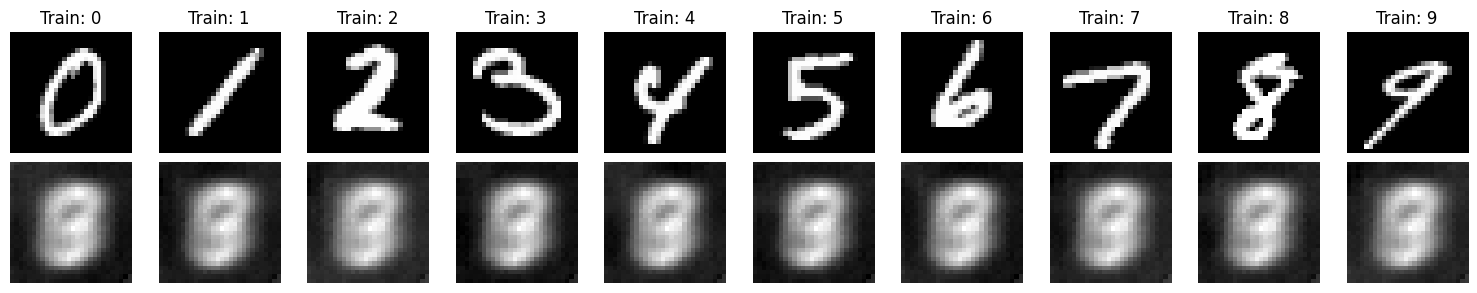

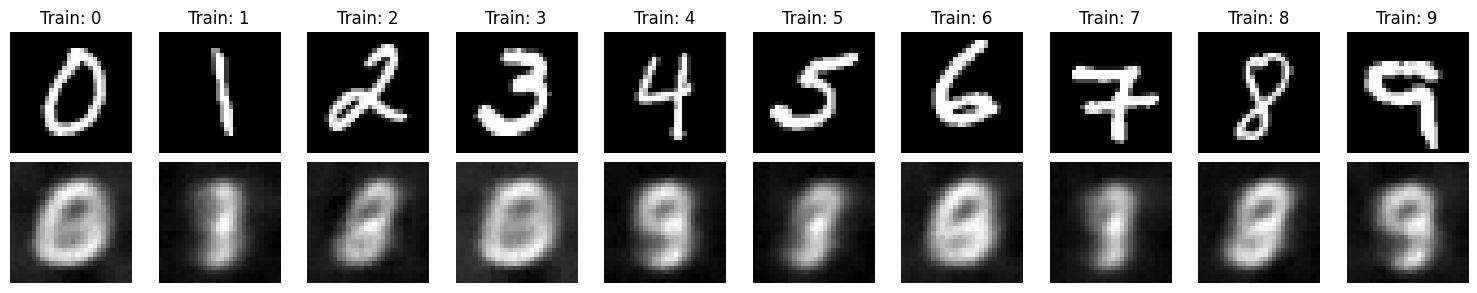

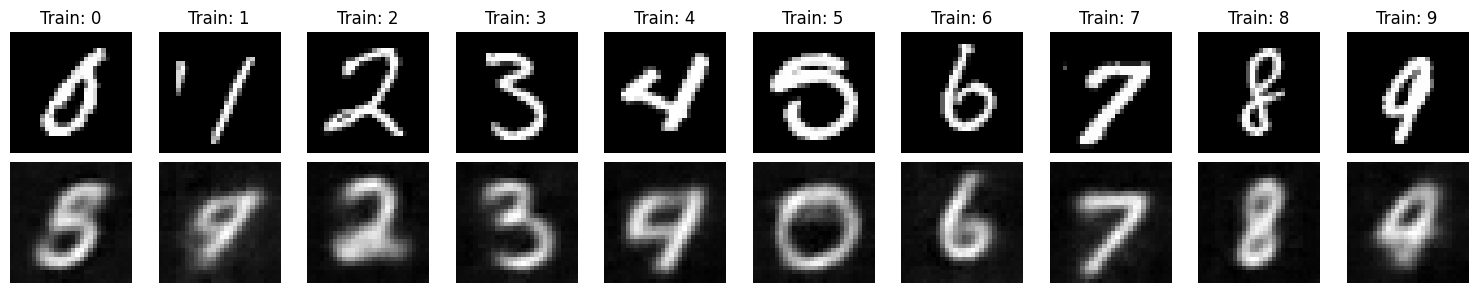

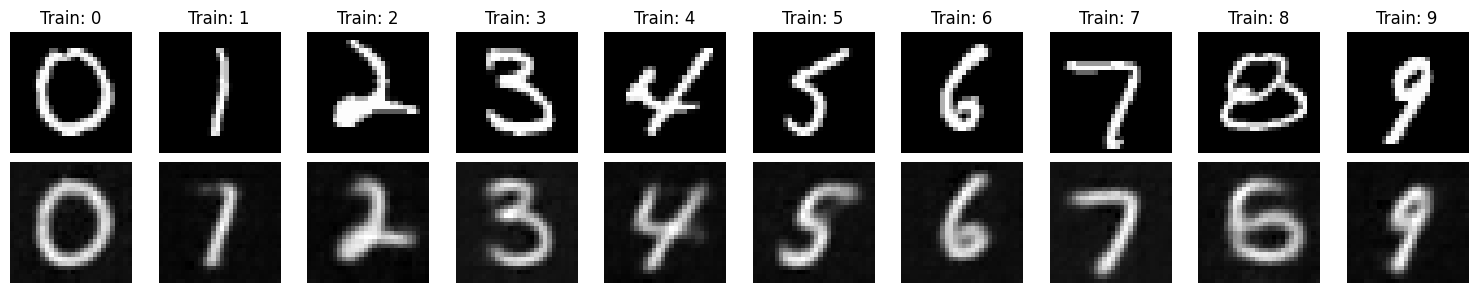

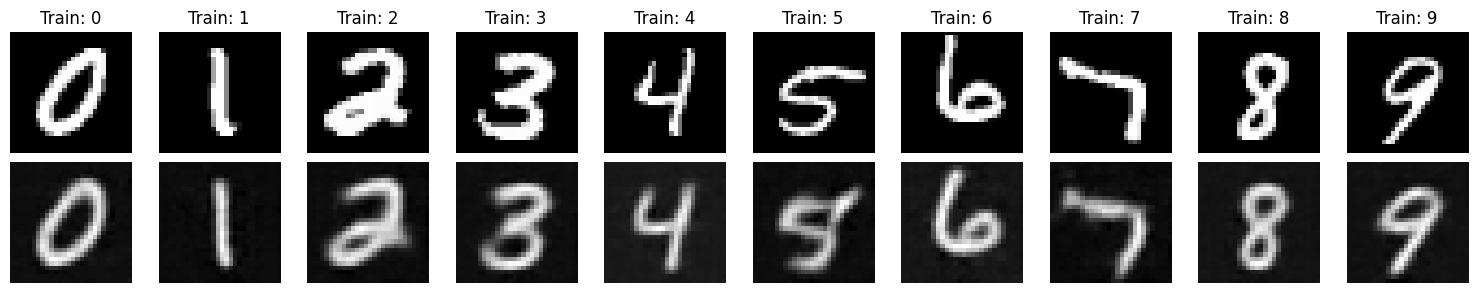

In [ ]:
def reconstruct_vae_latent(model):
  for epoch_num in [1, 5, 10, 20, 30]:
    model.load_state_dict(torch.load(f"vae_latent_epoch_{epoch_num}.pth"))
    model.eval()
    with torch.no_grad():
      # reconstruction
      train_images, train_mu, train_logvar = sample_one_image_per_label_latent(train_dataset, mu, log_var)
      recon_train = model(train_mu, train_logvar)
      plot_vae_reconstructions(train_images, recon_train, title_prefix="Train")
reconstruct_vae_latent(latent_model)

 Sample 10 latent variables from prior distribution and passing them to the generators of the latent optimization model to try sample imgs in epochs 1, 5, 10, 20, 30 as asked in Q3

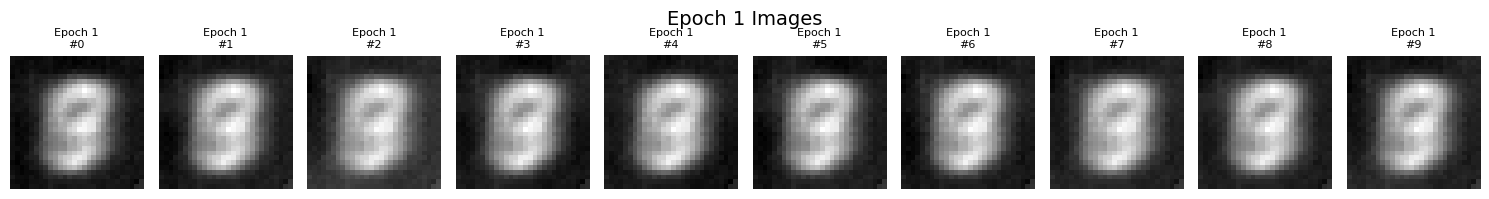

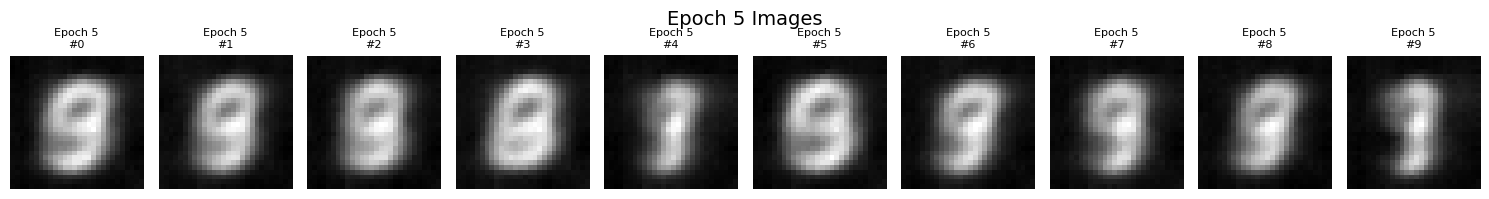

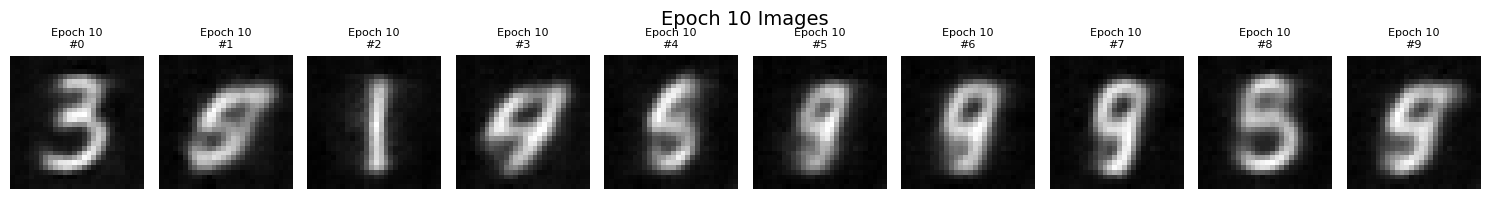

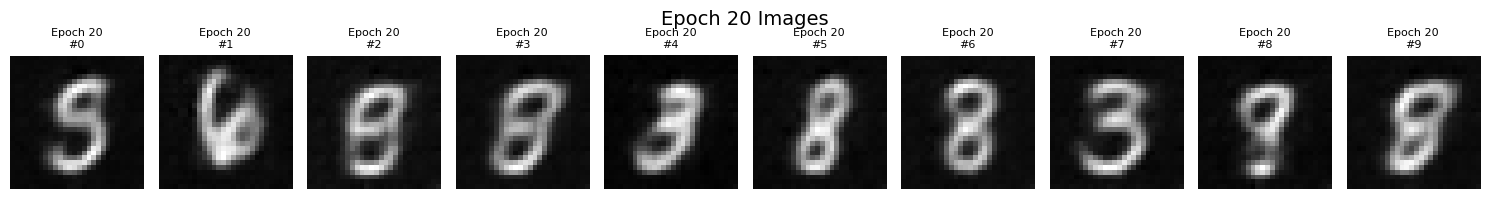

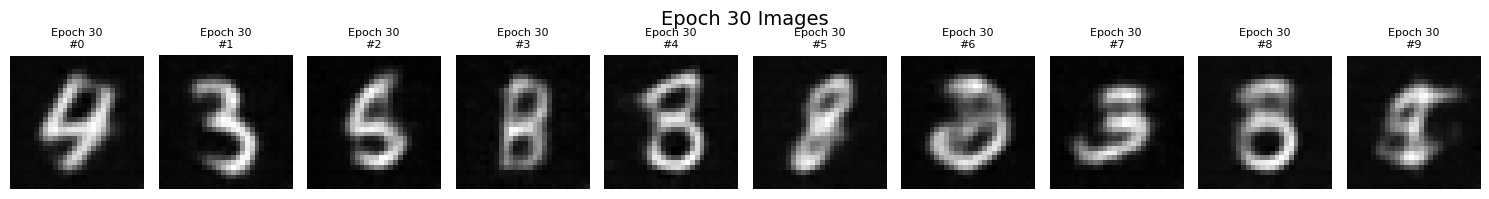

In [ ]:
sampling(latent_model, "vae_latent_epoch")

picking 10 randomaly imgs labeled 0 - 9 and plot log probability for each img as asked in Q4

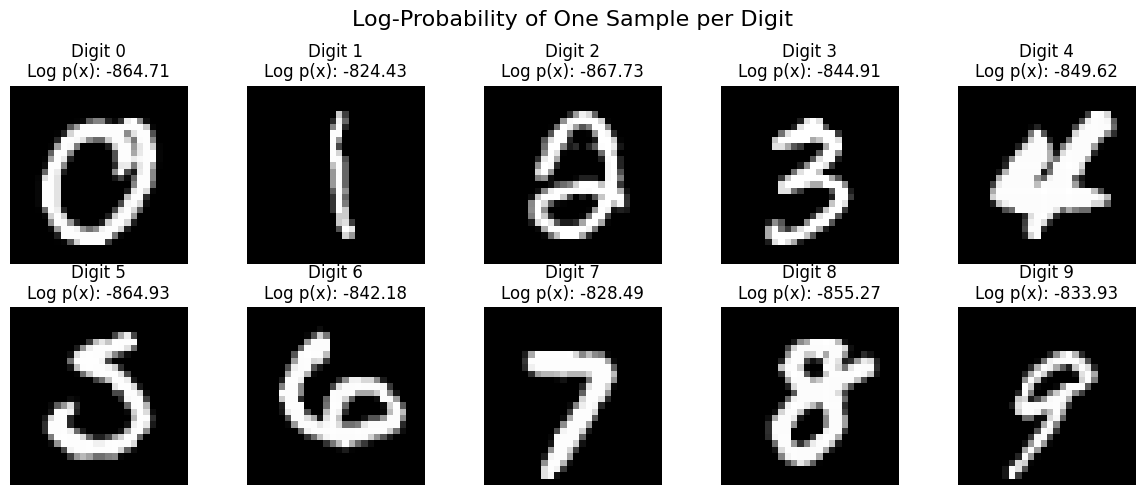

In [ ]:
vae_model.load_state_dict(torch.load("vae_epoch_30.pth"))
vae_model.eval()

images = sample_one_image_per_label(train_dataset)
log_probs = []

for img in images:
    log_px = compute_log_px(img, vae_model)
    log_probs.append(log_px.item())

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Digit {i}\nLog p(x): {log_probs[i]:.2f}")
    axes[i].axis('off')

plt.suptitle("Log-Probability of One Sample per Digit", fontsize=16)
plt.tight_layout()
plt.show()

as asked in Q4
1. calculate the average log probabilty for each digit
2. present average log probability for the train set imgs and test set imgs


In [ ]:
avg_prob_per_digit = []
trained_avg_prob_per_digit = []
test_avg_prob_per_digit = []


with torch.no_grad():
  vae_model.load_state_dict(torch.load(f"vae_epoch_30.pth"))
  vae_model.eval()
  for i in range(10):
    five_train_images = sample_five_images_for_label(train_dataset, i)
    five_test_images = sample_five_images_for_label(test_dataset, i)
    total_avg = 0
    avg_prob_per_set = 0
    for img in five_train_images:
      log_px = compute_log_px(img, vae_model)
      total_avg += log_px.item()

    avg_prob_per_set = total_avg
    trained_avg_prob_per_digit.append(avg_prob_per_set / 5 )
    avg_prob_per_set = 0
    for img in five_test_images:
      log_px = compute_log_px(img, vae_model)
      total_avg += log_px.item()
      avg_prob_per_set += log_px.item()

    avg_prob_per_set /= 5
    test_avg_prob_per_digit.append(avg_prob_per_set)
    total_avg /= 10
    avg_prob_per_digit.append(total_avg)

overall_train_avg = sum(trained_avg_prob_per_digit) / 10
overall_test_avg = sum(test_avg_prob_per_digit) / 10

print("Train set avg log-likelihood:", overall_train_avg)
print("Test set avg log-likelihood:", overall_test_avg)

Train set avg log-likelihood: -845.3514916992187
Test set avg log-likelihood: -846.9171301269532


plot the combined average log probability per digit as asked in Q4

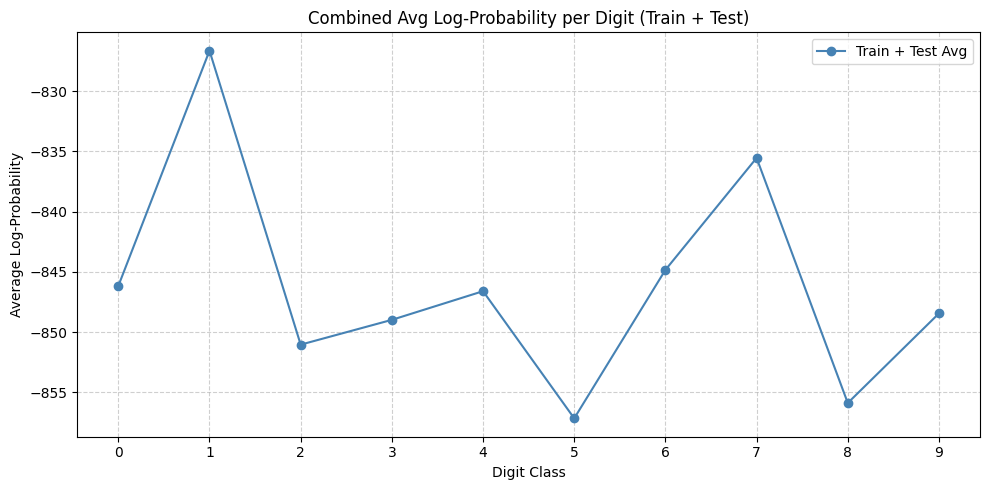

In [ ]:
digits = list(range(10))
plt.figure(figsize=(10, 5))
plt.plot(digits, avg_prob_per_digit, marker='o', linestyle='-', color='steelblue', label='Train + Test Avg')
plt.xlabel('Digit Class')
plt.ylabel('Average Log-Probability')
plt.title('Combined Avg Log-Probability per Digit (Train + Test)')
plt.xticks(digits)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()